In [1]:
## package imports ##
%load_ext autoreload
%autoreload 2

import sys
import os
import warnings
sys.path.append("../../src")
import utils.preprocessing_utils as process
import utils.query_utils as query
from utils.modelling_utils import QaD_correlation
import utils.modelling_utils as model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier, 
                              ExtraTreesClassifier)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix)
import synapseclient as sc
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

warnings.simplefilter("ignore")
sns.set_style("dark")
np.random.seed(100)
%matplotlib inline

In [2]:
## helper functions ## 
def annot_phone(params):
    """
    Function to annotate phone types
    parameter:
    `params`: raw phone type string
    
    returns an annotated dataset with lesser choice of phonetypes
    """
    if ";" in params:
        params = params.split(";")[0]
    if ("iPhone 6+" in params) or ("iPhone 6 Plus" in params):
        return "iPhone 6+"
    if ("iPhone9" in params) or ("Unknown" in params) or ("iPad" in params) or ("iPod" in params):
        return "Other iPhone"
    if ("iPhone 5" in params):
        return "iPhone 5"
    if ("iPhone8" in params):
        return "iPhone 8"
    if ("iPhone X" in params) or ("iPhone10" in params):
        return "iPhone X"
    return params


def plot_distribution(data):
    """
    Function to plot several metadata information accross version 
    parameter:
    `data`  : dataframe
    
    returns a distribution of mpower users
    """
    dataV1 = data[data["version"] == "mpower_v1"]
    dataV2 = data[data["version"] == "mpower_v2"]
    fig, axes = plt.subplots(nrows = 1, ncols = 3)
    sns.distplot(dataV2["age"].dropna(), label = "V2", ax = axes[0])
    sns.distplot(dataV1["age"].dropna(), label = "V1", ax = axes[0])
    axes[0].legend()
    axes[0].set_title("Age distribution of V1 and V2")
    axes[0].grid()
    axes[0].figure.set_size_inches(15,5)
    sns.countplot(data["PD"], hue = data["version"], ax = axes[1])
    axes[1].legend()
    axes[1].set_title("PD distribution of V1 and V2")
    axes[1].grid()
    axes[1].figure.set_size_inches(15,5)
    sns.countplot(data["gender"], hue = data["version"], ax = axes[2])
    axes[2].legend()
    axes[2].set_title("gender distribution of V1 and V2")
    axes[2].grid()
    axes[2].figure.set_size_inches(15,5)
    
    
 
    
def generate_pc_plots(data, feat_cols, metadata_cols, target):
    
    """
    Function to implement PCA with 2 components, 
    separate them with a certain target variable to see differences
    parameter: `data`          : the dataframe,
               `feat_cols`     : the feature columns,
               `metadata_cols` : the metadata columns,
               `target`        : the target variable to group on
    returns a generated report of PCA-1 vs PCA-2 plots of metadata and walking features 
    separated by its groups (PD, version) and prediction performances
    """   
    X_feat     = data[feat_cols]
    X_metadata = data[metadata_cols]
    y = data[["version", "healthCode", "PD"]]
    
    rf_model = RandomForestClassifier(random_state = 100)
    X_train, X_test, y_train, y_test = train_test_split(X_feat, 
                                                        y[target],
                                                        test_size = 0.2,
                                                        random_state = 100)
    rf_model.fit(X_train, y_train)
    print("#################### PREDICTION ON %s ################\n" %target)
    print(classification_report(rf_model.predict(X_test), y_test))
    
    
    ## plot PCA plots on first and second principal components ## 
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))
    principal_df = model.create_pc_dataframe(X_feat, y)
    sns.scatterplot(principal_df[0], 
                    principal_df[1], 
                    hue = principal_df[target], 
                    ax = axes[0])
    axes[0].set_title("PCA plot on Walking Features")
    axes[0].set_ylabel("PC2")
    axes[0].set_xlabel("PC1")
    axes[0].grid()
    
    principal_df = model.create_pc_dataframe(X_metadata, y)
    sns.scatterplot(principal_df[0], principal_df[1], 
                    hue = principal_df[target], ax = axes[1])
    axes[1].set_title("PCA plot on metadata")
    axes[1].set_ylabel("PC2")
    axes[1].set_xlabel("PC1")
    axes[1].grid()
    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    plt.show()
    

def version_balance_hc(data, matching_columns):
    
    """
    Function to create paired healthcodes
    takes in a dataset of PDKIT features
    matching methods:
    Join version 1 and version 2 table by leveraging designated matching columns
       -> tie breakers will be determined by choosing smaller age differences between pairs
        to sustain age distributions 
        
    parameters:
    `data`             : dataframe
    `matching_columns` : columns to do matching on 
    
    return a matched dataset 
    """
    
    ref = pd.pivot_table(data = data, index = "phone_type", columns = "version", values = "PD", aggfunc = "count")
    list_of_spans = ref.loc[(ref["mpower_v1"] > 0) & (ref["mpower_v2"] > 0)].index
    data = data[data["phone_type"].isin(list_of_spans)].reset_index(drop = True)
    hcx_used = []
    hcy_used = []
    V1 = data[data["version"] == "mpower_v1"][["healthCode", "version", "phone_type", "gender", "PD", "age"]]
    V2 = data[data["version"] == "mpower_v2"][["healthCode", "version", "phone_type", "gender", "PD", "age"]]
    tst_data = pd.merge(V1, V2, on = matching_columns, how = "inner")
    tst_data["age_diff"] = np.abs(tst_data["age_x"] - tst_data["age_y"])
    tst_data = tst_data.sort_values("age_diff").reset_index(drop = True)
    for hc_x, hc_y in zip(tst_data["healthCode_x"], tst_data["healthCode_y"]):
        if (hc_y not in hcy_used) and (hc_x not in hcx_used):
            hcy_used.append(hc_y)
            hcx_used.append(hc_x)
    lst = hcx_used + hcy_used
    return data[data["healthCode"].isin(lst)]

# Introduction:

This notebook will explore matching in reducing confounding effects between changes in different versions. To compare metadata, PCA analysis and one-way ANOVA test will be conducted, therefore data are required to be comparable. Therefore, additional processing steps are taken such as,

- One hot encoding of the phone type
- One hot encoding of the version
- One hot encoding of gender
- Drop the first one hot encoded variables to avoid collinearity

Afterwards, several matching of cases (by combination of metadata matchings) will be analyzed to see whether the confounding effects can be curated

- phone type matching to subject in version 1 and those in version 2
- phone type and gender matching in version 1 and those in version 2
- phone type, PD and gender matching in version 1 and version 2

Visualized PCA of PC1 vs PC2 of walking features and metadata will be assessed to see if there is still any separations between two versions. A simple baseline classifier (random forest) will be implemented to see whether the model can actually predict the versions of the mobile app, which is a good benchmark towards knowing whether there are still confounding effects sourced from the metadata.

In [35]:
syn = sc.login()
data = query.get_file_entity(syn, "syn21281633")

Welcome, aryton tediarjo!



In [36]:
## concatenate dataset and annotate iphone type ## 
dataV1 = data[data["version"] == "mpower_v1"]
dataV2 = data[data["version"] == "mpower_v2"]
data = pd.concat([dataV1, dataV2]).reset_index(drop = True)
data = process.addFeatures().transform(data)
data = process.collapseFeatures().transform(data)
data["phone_type"] = data["phoneInfo"].apply(annot_phone)

### Type of phones that span accross versions 

In [37]:
pd.pivot_table(data = data, index = "phone_type", columns = "version", values = "PD", aggfunc = "count")

version,mpower_v1,mpower_v2
phone_type,,
Other iPhone,90.0,29.0
iPhone 4S,17.0,NaN
iPhone 5,1139.0,8.0
iPhone 6,2016.0,37.0
iPhone 6+,1256.0,12.0
iPhone 6S,NaN,30.0
iPhone 6S+,NaN,12.0
iPhone 7,NaN,39.0
iPhone 7+,NaN,26.0


### Type of phones and PD subject that span accross versions 

In [38]:
pd.pivot_table(data    = data, 
               index   = "phone_type", 
               columns = ["version", "PD"], 
               values  = "healthCode", 
               aggfunc = "count")

version      mpower_v1        mpower_v2      
PD                 0.0    1.0       0.0   1.0
phone_type                                   
Other iPhone      20.0   70.0       8.0  21.0
iPhone 4S          3.0   14.0       NaN   NaN
iPhone 5         749.0  390.0       NaN   8.0
iPhone 6        1566.0  450.0       5.0  32.0
iPhone 6+        999.0  257.0       NaN  12.0
iPhone 6S          NaN    NaN       6.0  24.0
iPhone 6S+         NaN    NaN       NaN  12.0
iPhone 7           NaN    NaN       7.0  32.0
iPhone 7+          NaN    NaN       3.0  23.0
iPhone 8          85.0  165.0       6.0  32.0
iPhone 8+          NaN    NaN       3.0  15.0
iPhone SE          NaN    NaN       1.0  15.0
iPhone X           8.0   29.0       9.0  26.0

From the tabular dataframe above, we can see that there are only several phones that spans accross the two versions. Especially when broken down further to matching by their PDs status, there will be an issue where we will not get enough controls as most of the controls are not recruited to the version two studies (yet)

# Visualization & Intepretation

### 1.) Pre-matching Dataset (default)

In [39]:
## get encoded data
encoded_data = model.one_hot_encode(data, "phone_type", "gender", "version")
OHE_cols = [feat for feat in encoded_data.columns if ("OHE" in feat) or ("age" in feat) or ("PD" in feat)]

## column feature lists
walking_feat_cols = [feat for feat in data.columns if "." in feat]
metadata_feat_cols = [feat for feat in data.columns if ("." not in feat) and ("healthCode" not in feat)]

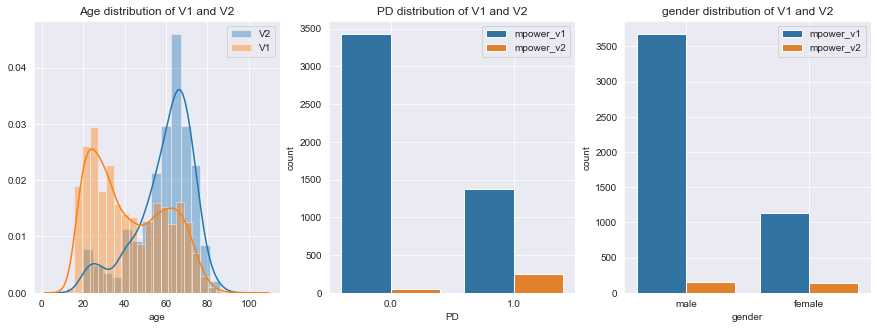

In [40]:
plot_distribution(encoded_data[metadata_feat_cols])

#################### PREDICTION ON version ################

              precision    recall  f1-score   support

   mpower_v1       0.99      0.97      0.98       985
   mpower_v2       0.40      0.64      0.49        36

    accuracy                           0.95      1021
   macro avg       0.70      0.80      0.74      1021
weighted avg       0.97      0.95      0.96      1021



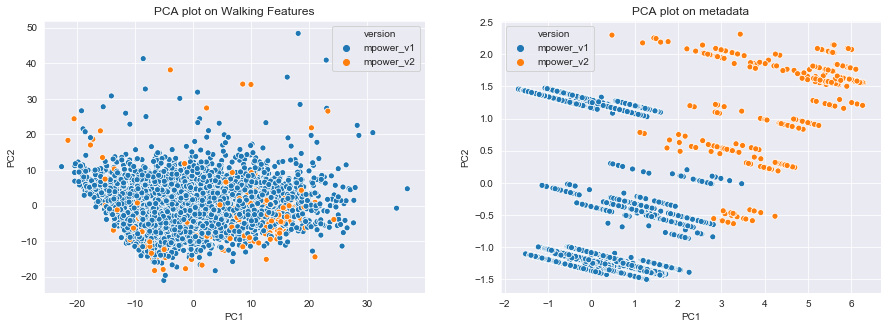

#################### PREDICTION ON PD ################

              precision    recall  f1-score   support

         0.0       0.92      0.80      0.86       811
         1.0       0.49      0.74      0.59       210

    accuracy                           0.79      1021
   macro avg       0.71      0.77      0.72      1021
weighted avg       0.83      0.79      0.80      1021



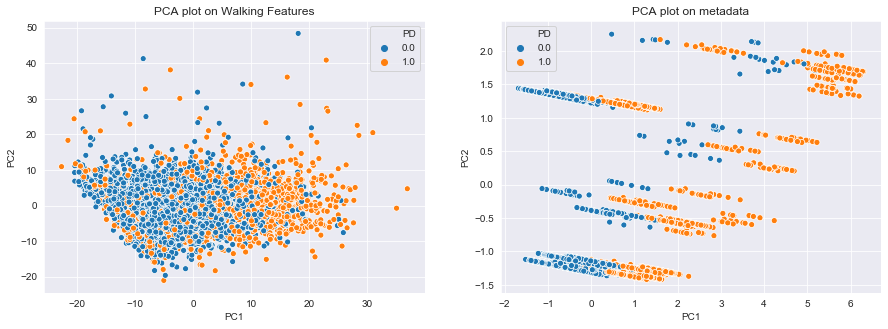

In [41]:
generate_pc_plots(encoded_data, walking_feat_cols, OHE_cols, "version")
generate_pc_plots(encoded_data, walking_feat_cols, OHE_cols, "PD")

The prematching plot shows that there is separation accross the versions, which means that there might be some signals on the metadata. As seen from how a simple logistic regression are able to can the versions with very good accuracy, it is imperative to match our dataset to see whether this issue is still happening given that users are having the same metadata

### 2.) Matched Data by Phone Types

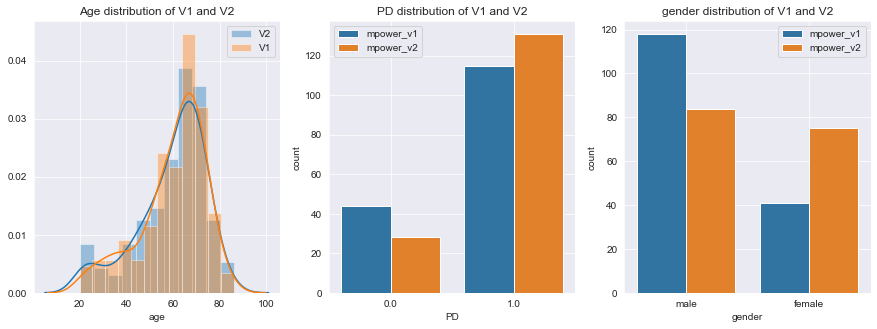

In [42]:
balance_hc_data = version_balance_hc(encoded_data, ["phone_type"]).reset_index(drop = True)
plot_distribution(balance_hc_data[metadata_feat_cols])

#################### PREDICTION ON version ################

              precision    recall  f1-score   support

   mpower_v1       0.61      0.76      0.68        29
   mpower_v2       0.75      0.60      0.67        35

    accuracy                           0.67        64
   macro avg       0.68      0.68      0.67        64
weighted avg       0.69      0.67      0.67        64



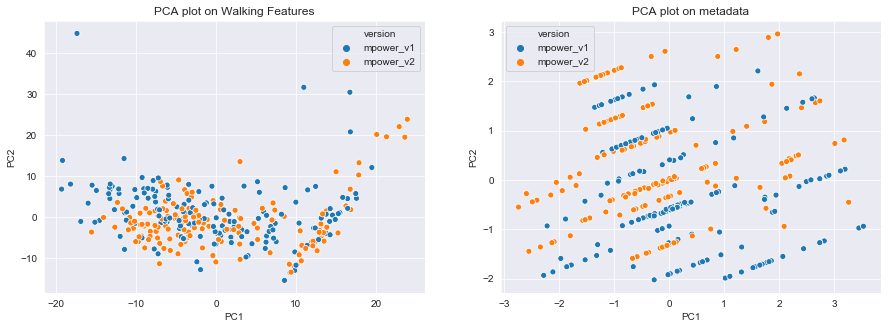

#################### PREDICTION ON PD ################

              precision    recall  f1-score   support

         0.0       0.55      0.60      0.57        10
         1.0       0.92      0.91      0.92        54

    accuracy                           0.86        64
   macro avg       0.73      0.75      0.74        64
weighted avg       0.87      0.86      0.86        64



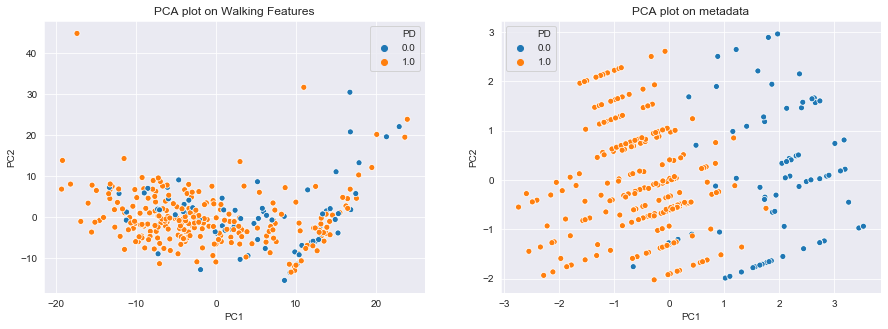

In [43]:
generate_pc_plots(balance_hc_data, walking_feat_cols, OHE_cols, "version")
generate_pc_plots(balance_hc_data, walking_feat_cols, OHE_cols, "PD")

By matching using spanning phone types, gender, and closest age differences, we can see that PCs are more evenly spread accross version 1 and version 2, however still slightly separable as most of the version 1 is on the upper area of the plot. In terms of its walking features, it is apparent that version 1 and version 2 is still linearly separable from each other. 

The reason why most of the V1s are lying on top is due to the uneven distribution of non-PD in our data collections, especially as most of the V1 has far more Non-PD data.

### 3.) Matched Dataset by Phone Types, Gender, and PD

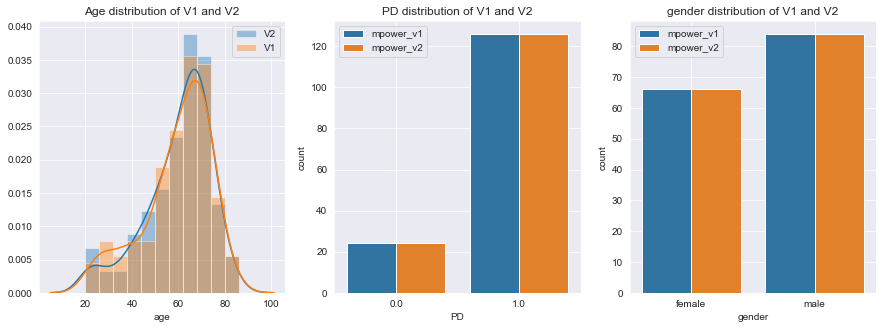

In [44]:
balance_hc_data = version_balance_hc(encoded_data, ["phone_type", "PD", "gender"]).reset_index(drop = True)
plot_distribution(balance_hc_data[metadata_feat_cols])

#################### PREDICTION ON version ################

              precision    recall  f1-score   support

   mpower_v1       0.84      0.79      0.82        34
   mpower_v2       0.75      0.81      0.78        26

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60



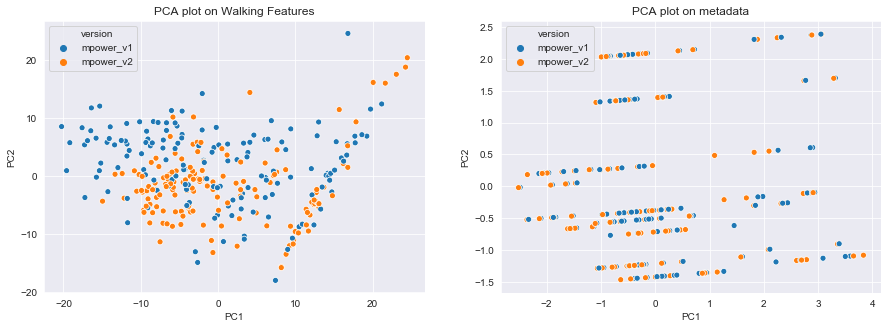

#################### PREDICTION ON PD ################

              precision    recall  f1-score   support

         0.0       0.09      0.20      0.13         5
         1.0       0.92      0.82      0.87        55

    accuracy                           0.77        60
   macro avg       0.50      0.51      0.50        60
weighted avg       0.85      0.77      0.80        60



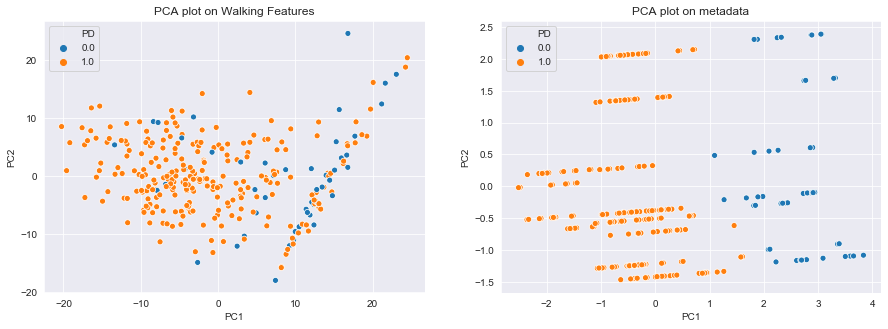

In [45]:
generate_pc_plots(balance_hc_data, walking_feat_cols, OHE_cols, "version")
generate_pc_plots(balance_hc_data, walking_feat_cols, OHE_cols, "PD")

# Metadata Associations

This section will see whether each metadata still has association towards other metadatas, we will test the subgroups of whether the subject is_male, is_v2, is_PD 
against each of the metadata. The ideal case is to have large p-value (>0.05), meaning that the metadata association is almost nonexistent to all the other metadata. However if p-value is extremely low we will assume that there are some associations on the metadata to other metadata, which is something that we would like to avoid.

## One-Way Anova Association on Metadata

In [46]:
def print_pvals_ftest(data, group):
    OHE_cols = [feat for feat in data.columns if ("OHE" in feat) or ("age" in feat) or ("PD" in feat)]
    return QaD_correlation(data[group], data[OHE_cols])

## 1.) Before Matching

In [47]:
print("### Gender ####")
print_pvals_ftest(encoded_data, "OHE_is_male")

### Gender ####


PD                   6.582714e-43
age                  5.282048e-29
OHE_is_iPhone 4S     3.208020e-01
OHE_is_iPhone 5      5.676407e-04
OHE_is_iPhone 6      2.714088e-04
OHE_is_iPhone 6+     1.668917e-11
OHE_is_iPhone 6S     8.093628e-06
OHE_is_iPhone 6S+    1.786965e-01
OHE_is_iPhone 7      5.511032e-04
OHE_is_iPhone 7+     1.196633e-02
OHE_is_iPhone 8      1.130260e-11
OHE_is_iPhone 8+     2.578676e-03
OHE_is_iPhone SE     5.562322e-01
OHE_is_iPhone X      5.218718e-02
OHE_is_male          0.000000e+00
OHE_is_mpower_v2     9.804982e-22
dtype: float64

In [48]:
print("### age ###")
print_pvals_ftest(encoded_data, "age")

### age ###


PD                   0.000000e+00
age                  0.000000e+00
OHE_is_iPhone 4S     7.379811e-07
OHE_is_iPhone 5      2.614925e-01
OHE_is_iPhone 6      8.241516e-20
OHE_is_iPhone 6+     4.000786e-06
OHE_is_iPhone 6S     9.107185e-06
OHE_is_iPhone 6S+    3.541837e-04
OHE_is_iPhone 7      8.692488e-10
OHE_is_iPhone 7+     2.651059e-06
OHE_is_iPhone 8      4.820114e-21
OHE_is_iPhone 8+     1.902987e-02
OHE_is_iPhone SE     7.605311e-05
OHE_is_iPhone X      4.854543e-10
OHE_is_male          5.282048e-29
OHE_is_mpower_v2     2.755561e-58
dtype: float64

In [49]:
## association in version groupings
print("### version ###")
print_pvals_ftest(encoded_data, "OHE_is_mpower_v2")

### version ###


PD                    2.785495e-92
age                   2.755561e-58
OHE_is_iPhone 4S      3.021842e-01
OHE_is_iPhone 5       1.929556e-17
OHE_is_iPhone 6       1.958413e-24
OHE_is_iPhone 6+      5.638408e-18
OHE_is_iPhone 6S     2.187281e-112
OHE_is_iPhone 6S+     1.350009e-44
OHE_is_iPhone 7      4.821884e-148
OHE_is_iPhone 7+      6.221450e-97
OHE_is_iPhone 8       5.252654e-08
OHE_is_iPhone 8+      1.046289e-66
OHE_is_iPhone SE      2.758660e-59
OHE_is_iPhone X       1.242968e-55
OHE_is_male           9.804982e-22
OHE_is_mpower_v2      0.000000e+00
dtype: float64

In [50]:
## association in duration groupings
print("### PD ###")
print_pvals_ftest(encoded_data, "PD")

### PD ###


PD                   0.000000e+00
age                  0.000000e+00
OHE_is_iPhone 4S     7.548950e-06
OHE_is_iPhone 5      1.955526e-02
OHE_is_iPhone 6      2.665194e-26
OHE_is_iPhone 6+     4.039075e-21
OHE_is_iPhone 6S     1.334755e-08
OHE_is_iPhone 6S+    3.856361e-07
OHE_is_iPhone 7      1.337527e-11
OHE_is_iPhone 7+     5.015182e-10
OHE_is_iPhone 8      1.884141e-43
OHE_is_iPhone 8+     2.629666e-06
OHE_is_iPhone SE     1.002640e-07
OHE_is_iPhone X      2.628523e-16
OHE_is_male          6.582714e-43
OHE_is_mpower_v2     2.785495e-92
dtype: float64

## 2.) After Phone Type, Gender Based (Treatment: Version)

In [51]:
balance_hc_data = version_balance_hc(encoded_data, ["phone_type", "gender"]).reset_index(drop = True)

In [52]:
print("### gender ###")
print_pvals_ftest(balance_hc_data, "OHE_is_male")

### gender ###


PD                   0.172811
age                  0.706700
OHE_is_iPhone 4S     1.000000
OHE_is_iPhone 5      0.620633
OHE_is_iPhone 6      0.354985
OHE_is_iPhone 6+     0.141201
OHE_is_iPhone 6S     1.000000
OHE_is_iPhone 6S+    1.000000
OHE_is_iPhone 7      1.000000
OHE_is_iPhone 7+     1.000000
OHE_is_iPhone 8      0.022039
OHE_is_iPhone 8+     1.000000
OHE_is_iPhone SE     1.000000
OHE_is_iPhone X      0.034595
OHE_is_male          0.000000
OHE_is_mpower_v2     1.000000
dtype: float64

In [53]:
print("### age ###")
print_pvals_ftest(balance_hc_data, "age")

### age ###


PD                   1.497978e-18
age                  0.000000e+00
OHE_is_iPhone 4S     1.000000e+00
OHE_is_iPhone 5      6.150723e-03
OHE_is_iPhone 6      4.922739e-01
OHE_is_iPhone 6+     1.370063e-04
OHE_is_iPhone 6S     1.000000e+00
OHE_is_iPhone 6S+    1.000000e+00
OHE_is_iPhone 7      1.000000e+00
OHE_is_iPhone 7+     1.000000e+00
OHE_is_iPhone 8      6.818840e-01
OHE_is_iPhone 8+     1.000000e+00
OHE_is_iPhone SE     1.000000e+00
OHE_is_iPhone X      1.653260e-02
OHE_is_male          7.066996e-01
OHE_is_mpower_v2     9.935880e-01
dtype: float64

In [54]:
print("### version ###")
print_pvals_ftest(balance_hc_data, "OHE_is_mpower_v2")

### version ###


PD                   0.012967
age                  0.993588
OHE_is_iPhone 4S     1.000000
OHE_is_iPhone 5      1.000000
OHE_is_iPhone 6      1.000000
OHE_is_iPhone 6+     1.000000
OHE_is_iPhone 6S     1.000000
OHE_is_iPhone 6S+    1.000000
OHE_is_iPhone 7      1.000000
OHE_is_iPhone 7+     1.000000
OHE_is_iPhone 8      1.000000
OHE_is_iPhone 8+     1.000000
OHE_is_iPhone SE     1.000000
OHE_is_iPhone X      1.000000
OHE_is_male          1.000000
OHE_is_mpower_v2     0.000000
dtype: float64

In [55]:
print("### PD ###")
print_pvals_ftest(balance_hc_data, "PD")

### PD ###


PD                   0.000000e+00
age                  1.497978e-18
OHE_is_iPhone 4S     1.000000e+00
OHE_is_iPhone 5      1.076646e-01
OHE_is_iPhone 6      2.994394e-04
OHE_is_iPhone 6+     2.162091e-01
OHE_is_iPhone 6S     1.000000e+00
OHE_is_iPhone 6S+    1.000000e+00
OHE_is_iPhone 7      1.000000e+00
OHE_is_iPhone 7+     1.000000e+00
OHE_is_iPhone 8      1.813692e-01
OHE_is_iPhone 8+     1.000000e+00
OHE_is_iPhone SE     1.000000e+00
OHE_is_iPhone X      7.753349e-01
OHE_is_male          1.728110e-01
OHE_is_mpower_v2     1.296738e-02
dtype: float64

## 3.) By Phone Type, Gender, PD Matching

In [56]:
balance_hc_data = version_balance_hc(encoded_data, 
                                     ["phone_type", "gender", "PD"]).reset_index(drop = True)

In [57]:
print("### gender ###")
print_pvals_ftest(balance_hc_data, "OHE_is_male")

### gender ###


PD                   0.723423
age                  0.856389
OHE_is_iPhone 4S     1.000000
OHE_is_iPhone 5      0.620633
OHE_is_iPhone 6      0.354985
OHE_is_iPhone 6+     0.141201
OHE_is_iPhone 6S     1.000000
OHE_is_iPhone 6S+    1.000000
OHE_is_iPhone 7      1.000000
OHE_is_iPhone 7+     1.000000
OHE_is_iPhone 8      0.022039
OHE_is_iPhone 8+     1.000000
OHE_is_iPhone SE     1.000000
OHE_is_iPhone X      0.034595
OHE_is_male          0.000000
OHE_is_mpower_v2     1.000000
dtype: float64

In [58]:
print("### age ###")
print_pvals_ftest(balance_hc_data, "age")

### age ###


PD                   7.382818e-40
age                  0.000000e+00
OHE_is_iPhone 4S     1.000000e+00
OHE_is_iPhone 5      5.560010e-03
OHE_is_iPhone 6      5.697217e-01
OHE_is_iPhone 6+     1.405375e-04
OHE_is_iPhone 6S     1.000000e+00
OHE_is_iPhone 6S+    1.000000e+00
OHE_is_iPhone 7      1.000000e+00
OHE_is_iPhone 7+     1.000000e+00
OHE_is_iPhone 8      7.849798e-01
OHE_is_iPhone 8+     1.000000e+00
OHE_is_iPhone SE     1.000000e+00
OHE_is_iPhone X      6.085079e-02
OHE_is_male          8.563893e-01
OHE_is_mpower_v2     7.431381e-01
dtype: float64

In [59]:
print("### version ###")
print_pvals_ftest(balance_hc_data, "OHE_is_mpower_v2")

### version ###


PD                   1.000000
age                  0.743138
OHE_is_iPhone 4S     1.000000
OHE_is_iPhone 5      1.000000
OHE_is_iPhone 6      1.000000
OHE_is_iPhone 6+     1.000000
OHE_is_iPhone 6S     1.000000
OHE_is_iPhone 6S+    1.000000
OHE_is_iPhone 7      1.000000
OHE_is_iPhone 7+     1.000000
OHE_is_iPhone 8      1.000000
OHE_is_iPhone 8+     1.000000
OHE_is_iPhone SE     1.000000
OHE_is_iPhone X      1.000000
OHE_is_male          1.000000
OHE_is_mpower_v2     0.000000
dtype: float64

In [60]:
print("### PD ###")
print_pvals_ftest(balance_hc_data, "PD")

### PD ###


PD                   0.000000e+00
age                  7.382818e-40
OHE_is_iPhone 4S     1.000000e+00
OHE_is_iPhone 5      7.320064e-02
OHE_is_iPhone 6      5.030733e-01
OHE_is_iPhone 6+     2.580827e-02
OHE_is_iPhone 6S     1.000000e+00
OHE_is_iPhone 6S+    1.000000e+00
OHE_is_iPhone 7      1.000000e+00
OHE_is_iPhone 7+     1.000000e+00
OHE_is_iPhone 8      9.539920e-01
OHE_is_iPhone 8+     1.000000e+00
OHE_is_iPhone SE     1.000000e+00
OHE_is_iPhone X      4.862344e-01
OHE_is_male          7.234225e-01
OHE_is_mpower_v2     1.000000e+00
dtype: float64

## Notes:

From the One-Way ANOVA test conducted above, we can see that by matching healthcodes by their phone types, we are able to translate the walking features and metadata from version 1 to version 2. Looking at the p-values, we can see that in the pre-matched features there seems to be a very low p values on most of the metadata features, however, by matching through phone types and other metadata, these associations are able to be minimized. Matching through all metadata seems to be performing the best, however this will reduce the number of subjects that we have in the mpower study.

## Old Issue: Separation in PCA of Walking Features

An old issue is that it is known that there are separation between the two versions, however, this only occurs whenever the version 1 data has been filtered with age-matched subjects from previous study. However, the analysis above has shown that by combining all the gait data altogether, and match users by their phone types will help translate walking features from version 1 to those in version 2. 

In [61]:
healthcode_list_v1 = query.get_file_entity(syn, "syn8381056").index
filtered_data = encoded_data[encoded_data["healthCode"].isin(healthcode_list_v1)]

In [62]:
healthcode_list_v1 = query.get_file_entity(syn, "syn8381056").index
v1 = encoded_data[encoded_data["version"] == "mpower_v1"].reset_index(drop = True)
v1 = v1[v1["healthCode"].isin(healthcode_list_v1)]
v2 = encoded_data[encoded_data["version"] == "mpower_v2"].reset_index(drop = True)
filtered_data = pd.concat([v1, v2]).reset_index(drop = True)

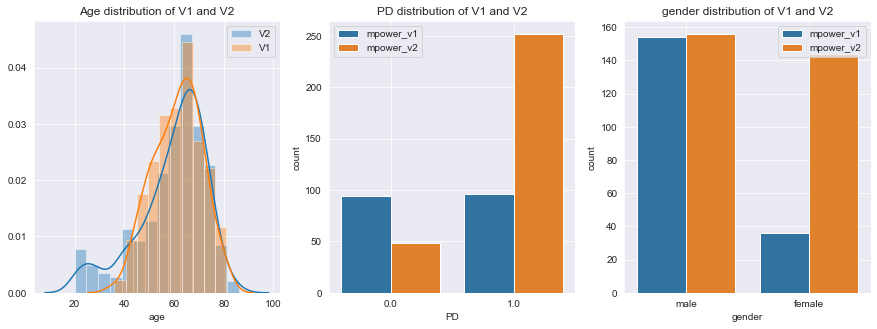

In [63]:
plot_distribution(filtered_data[metadata_feat_cols])

#################### PREDICTION ON version ################

              precision    recall  f1-score   support

   mpower_v1       0.97      1.00      0.99        37
   mpower_v2       1.00      0.98      0.99        61

    accuracy                           0.99        98
   macro avg       0.99      0.99      0.99        98
weighted avg       0.99      0.99      0.99        98



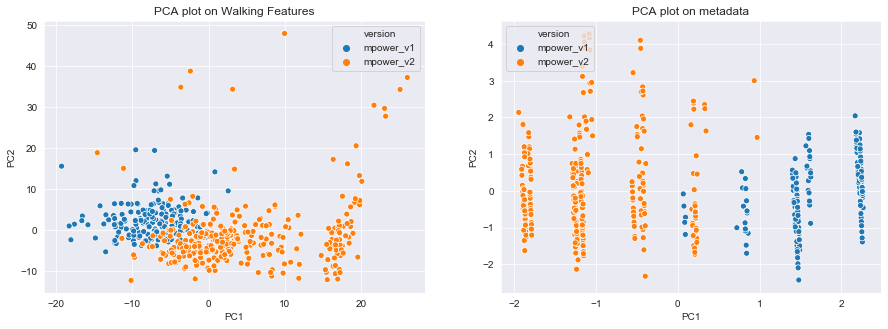

#################### PREDICTION ON PD ################

              precision    recall  f1-score   support

         0.0       0.47      0.68      0.56        22
         1.0       0.89      0.78      0.83        76

    accuracy                           0.76        98
   macro avg       0.68      0.73      0.69        98
weighted avg       0.80      0.76      0.77        98



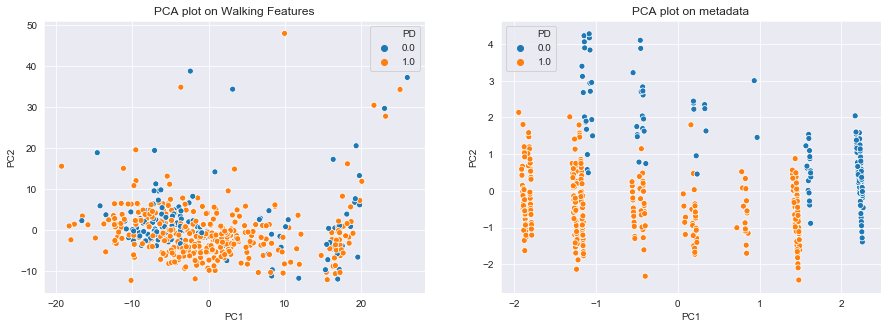

In [64]:
generate_pc_plots(filtered_data, walking_feat_cols, OHE_cols, "version")
generate_pc_plots(filtered_data, walking_feat_cols, OHE_cols, "PD")

## Save Notebook to Synapse

In [65]:
query.save_data_to_synapse(syn = syn,
                          data = "02.pca_matching.ipynb",
                          output_filename = '02.pca_matching.ipynb',
                          data_parent_id = "syn21448468",
                          source_table_id = "syn21281633",
                          remove = False)


##################################################
 Uploading file to Synapse storage 
##################################################

